In [1]:
from keras.models import Model
from keras.layers import Input
from keras.optimizers import *
from keras.datasets import mnist
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Local imports
from unet import unet_cell, LEAKY_RELU_ALPHA, BATCH_NORM_MOMENTUM
from builders import build_upscaler, build_upscaler_v2, build_discriminator
from utils import reduce_resolution

batch_size = 20
n_channels = 3
GRADIENT_PENALTY_WEIGHT = 10
import WGAN_utils
from WGAN_utils import wasserstein_loss, gradient_penalty_loss, RandomWeightedAverage
WGAN_utils.batch_size=batch_size

Using TensorFlow backend.


In [2]:
# Define inputs
low_res_input = Input(shape=(None, None, n_channels))
# TODO: dimensions of low_res_input should probably be divisible 
# by 2**{num_layers}
high_res_input = Input(shape=(None, None, n_channels)) # This should really have dimensions twice that of low_res_input

# Build upscaler / discriminator
upscaler = build_upscaler_v2(
    low_res_input, 
#     num_filters_in_layer=[16, 32, 64, 128],
#     num_cells_in_layer=[3, 3, 3, 3],
#     n_channels_output=n_channels, 
    activation_string='tanh',
    output_size=(128, 128),
    resize_method='nearest_neighbor',
    align_corners=True,
    num_filters_in_layer=[16*4, 32*4, 64*4, 32*4],
    num_cells_in_layer=[3, 3, 3, 3],
    bottleneck_before_concat=True)
preliminary_discriminator = build_discriminator(low_res_input, high_res_input, 
                                                num_filters_in_layer=[16*4, 32*4, 64*4, 128*4],
                                                num_cells_in_layer=[3, 3, 3, 3],
                                                use_batch_norm=False, 
                                                activation_in_final_layer=False, 
                                                num_units_in_dense_layer=[1024]) # Use default parameters


# Define optimizers and compile models
upscaler_optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
upscaler.compile(loss='binary_crossentropy', 
                 optimizer=upscaler_optimizer)

# Defines the forward pass for the discriminator.  This will be used for the combined
# model when training the generator, but the gradient loss function still has to
# be defined so it can be used in training the discriminator.  This model will
# be used to calculate the gradient loss and so has to be compiled now.
discriminator_optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
preliminary_discriminator.compile(loss='binary_crossentropy', 
                      optimizer=discriminator_optimizer, 
                      metrics=['accuracy'])

# We will compile the discriminator model before the combined model for the generator
# so the generator's weights should be frozen.
preliminary_discriminator.trainable = True
upscaler.trainable = False

# We need sample images produced by the generator and so that we can take a weighted
# average of the generated images and the real images to stochastically determine the
# effective gradients by passing this weighted average through the discriminator. We
# also use the inputs and outputs defined here to define the full discriminator model.
generator_input = Input(shape=(None, None, n_channels))
generated_samples = upscaler(generator_input)
discriminator_output_from_generator = preliminary_discriminator([generator_input, generated_samples])

low_res_input_for_discriminator = Input(shape=(None, None, n_channels))
real_samples = Input(shape=(None, None, n_channels))
discriminator_output_from_real_samples = preliminary_discriminator([low_res_input_for_discriminator, real_samples])

# We also need to generate weighted-averages of real and generated samples, to use for the gradient norm penalty.
averaged_samples = RandomWeightedAverage()([real_samples, generated_samples])
# We then run these samples through the discriminator as well. Note that we never really use the discriminator
# output for these samples - we're only running them to get the gradient norm for the gradient penalty loss.
averaged_samples_out = preliminary_discriminator([generator_input, averaged_samples])

# The gradient penalty loss function requires the input averaged samples to get gradients. However,
# Keras loss functions can only have two arguments, y_true and y_pred. We get around this by making a partial()
# of the function with the averaged samples here.
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gradient_penalty'  # Functions need names or Keras will throw an error

# Define model and compile it
discriminator = Model(inputs=[generator_input, low_res_input_for_discriminator, real_samples],
                            outputs=[discriminator_output_from_generator,
                                     discriminator_output_from_real_samples,
                                     averaged_samples_out])

discriminator.compile(optimizer=discriminator_optimizer,
                            loss=[wasserstein_loss,
                                  wasserstein_loss,
                                  partial_gp_loss], 
                      metrics = None)

# Freeze the discriminator weights and allow the generator to train
preliminary_discriminator.trainable = False
upscaler.trainable = True

# Define the input and output of the combined model.
low_res_input_for_combined_model = Input(shape=(None, None, n_channels))
upscaled_imgs = upscaler(low_res_input_for_combined_model)
valid = preliminary_discriminator([low_res_input_for_combined_model, upscaled_imgs])

# The combined model  (stacked upscaler and discriminator) takes
# low-res image as input and returns an upsampled image from the 
# upscaler and a validity score given by the discriminator
combined = Model(low_res_input_for_combined_model, [valid, upscaled_imgs])
combined.compile(loss=[wasserstein_loss, 'mean_squared_error'], 
                 optimizer=upscaler_optimizer, 
                 metrics = None)
# Notice: the combined model was compiled *after* freezing the discriminator's weights

print('combined summary')
combined.summary()
print('discriminator summary')
discriminator.summary()
print('preliminary_discriminator summary')
preliminary_discriminator.summary()
print('upscaler summary')
upscaler.summary()
print(discriminator.metrics_names)
print(combined.metrics_names)

combined summary
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128, 128, 3)  2140473     input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            8347841     input_6[0][0]                    
                                                                 model_1[2][0]                    
Total params: 10,488,314
Trainable params: 2,136,765
Non-trainable params: 8,351,549
__________________________________________________________________________________________________
discrim

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [3]:
import os
import cv2
path = "./data/conditioned_faces_final/"

def extract_image_sizes(directories):
    sizes = []
    for directory in directories:
        sizes.append(int(directory.split('x')[0]))
    return sizes
dirs = os.listdir(path)
image_sizes = extract_image_sizes(dirs)
print(dirs)
print(image_sizes)
im_names = []
for d in dirs:
    im_names.append(os.listdir(path + d))

for i, d in enumerate(im_names):
    print("%s (index %d) length: %d" % (dirs[i], i, len(d)))
c = 0
def load_batch(path2, filenames, indices):
    batch = []
    c = 0
    for i in indices:
        img = cv2.imread(path2 + filenames[i])
        batch.append(img)
        """
        if(c == 0):
            c += 1
            print(path + filenames[i])
            print(img.shape)
            plt.imshow(img)
            plt.show()
        """
    batch = (np.array(batch) / 127.5) - 1.0
    A, B, C, D = batch.shape
    e = B % 4
    f = C % 4
    return batch[:, :B-e, :C-f, :]
    
d = im_names[6]
batch_indices = np.random.randint(0, len(d), size=[batch_size])

path1 = path + dirs[6] + "/"

x_batch = load_batch(path1, d, batch_indices)



['100x100', '128x128', '180x180', '256x256', '310x310', '360x360', '410x410', '480x480', '530x530', '55x55', '590x590', '650x650', '700x700', '70x70', '86x86']
[100, 128, 180, 256, 310, 360, 410, 480, 530, 55, 590, 650, 700, 70, 86]
100x100 (index 0) length: 7119
128x128 (index 1) length: 12614
180x180 (index 2) length: 9567
256x256 (index 3) length: 3706
310x310 (index 4) length: 2384
360x360 (index 5) length: 925
410x410 (index 6) length: 443
480x480 (index 7) length: 282
530x530 (index 8) length: 91
55x55 (index 9) length: 8052
590x590 (index 10) length: 17
650x650 (index 11) length: 11
700x700 (index 12) length: 2
70x70 (index 13) length: 7654
86x86 (index 14) length: 7821


In [4]:
# Define training parameters
train_steps = 40000
print_every_n_steps = 200
print_results = True
plot_results = True
repeat_discriminator_training_n_times = 1
# batch_size defined in first cell

# Create a dictionary for storing training metrics over time
training_metrics = {
    'step': [],
    'd_total_loss': [],
    'd_w_fake_loss': [],
    'd_w_real_loss': [],
    'd_grad_loss': [],
    'g_total_loss': [], 
    'g_w_loss': [], 
    'g_MSE_loss': []
}

# We make three label vectors for training. positive_y is the label vector for real samples, with value 1.
# negative_y is the label vector for generated samples, with value -1. The dummy_y vector is passed to the
# gradient_penalty loss function and is not used.
positive_y = np.ones((batch_size, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step 200:
    [D losses: Total=-0.021088, Wass_fake=-0.064794, Wass_real=0.035319, Wass_grad=0.008388]
    [G losses: Total=0.065130, Wass=0.059639, MSE=0.005491]


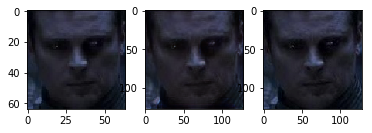

Step 400:
    [D losses: Total=-0.023270, Wass_fake=-0.071215, Wass_real=0.043384, Wass_grad=0.004561]
    [G losses: Total=0.081258, Wass=0.076062, MSE=0.005195]


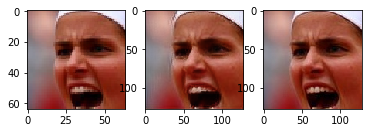

Step 600:
    [D losses: Total=-0.015821, Wass_fake=-0.057689, Wass_real=0.038078, Wass_grad=0.003790]
    [G losses: Total=0.065839, Wass=0.059478, MSE=0.006361]


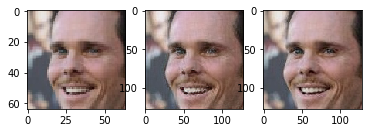

Step 800:
    [D losses: Total=-0.017849, Wass_fake=-0.059469, Wass_real=0.036875, Wass_grad=0.004745]
    [G losses: Total=0.073072, Wass=0.068926, MSE=0.004146]


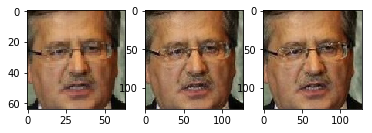

Step 1000:
    [D losses: Total=0.025633, Wass_fake=-0.068359, Wass_real=0.030755, Wass_grad=0.063237]
    [G losses: Total=0.067340, Wass=0.061326, MSE=0.006014]


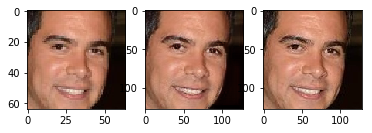

Step 1200:
    [D losses: Total=-0.007915, Wass_fake=-0.075223, Wass_real=0.049399, Wass_grad=0.017909]
    [G losses: Total=0.093300, Wass=0.087836, MSE=0.005464]


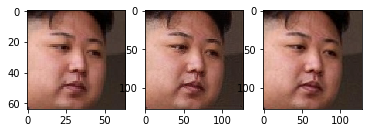

Step 1400:
    [D losses: Total=0.001524, Wass_fake=-0.087058, Wass_real=0.060818, Wass_grad=0.027764]
    [G losses: Total=0.086297, Wass=0.081357, MSE=0.004940]


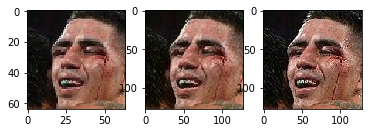

Step 1600:
    [D losses: Total=-0.017168, Wass_fake=-0.056485, Wass_real=0.036902, Wass_grad=0.002415]
    [G losses: Total=0.055439, Wass=0.049662, MSE=0.005777]


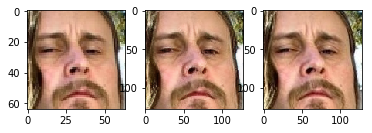

Step 1800:
    [D losses: Total=0.008445, Wass_fake=-0.069755, Wass_real=0.043335, Wass_grad=0.034865]
    [G losses: Total=0.066296, Wass=0.061787, MSE=0.004509]


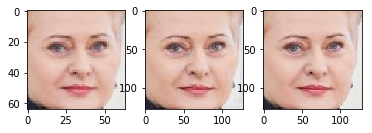

Step 2000:
    [D losses: Total=-0.019050, Wass_fake=-0.063217, Wass_real=0.041676, Wass_grad=0.002491]
    [G losses: Total=0.072201, Wass=0.067389, MSE=0.004811]


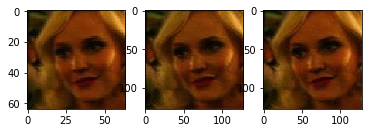

Step 2200:
    [D losses: Total=0.057628, Wass_fake=-0.051906, Wass_real=0.024473, Wass_grad=0.085062]
    [G losses: Total=0.066271, Wass=0.061344, MSE=0.004927]


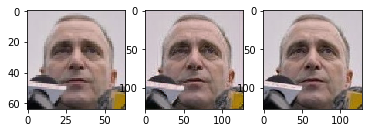

Step 2400:
    [D losses: Total=-0.009383, Wass_fake=-0.059354, Wass_real=0.041036, Wass_grad=0.008935]
    [G losses: Total=0.078418, Wass=0.073005, MSE=0.005414]


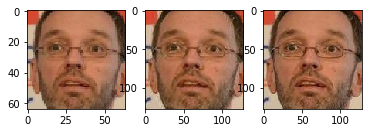

Step 2600:
    [D losses: Total=-0.014990, Wass_fake=-0.057046, Wass_real=0.035829, Wass_grad=0.006227]
    [G losses: Total=0.066200, Wass=0.059916, MSE=0.006284]


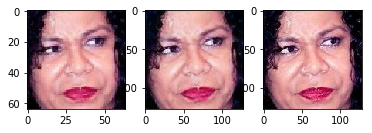

Step 2800:
    [D losses: Total=-0.013105, Wass_fake=-0.051518, Wass_real=0.031882, Wass_grad=0.006531]
    [G losses: Total=0.066766, Wass=0.061351, MSE=0.005415]


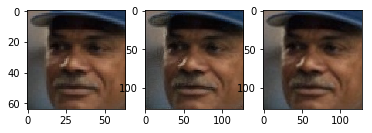

Step 3000:
    [D losses: Total=-0.015559, Wass_fake=-0.054868, Wass_real=0.038159, Wass_grad=0.001150]
    [G losses: Total=0.058987, Wass=0.054760, MSE=0.004227]


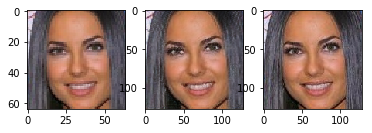

Step 3200:
    [D losses: Total=-0.020146, Wass_fake=-0.074669, Wass_real=0.038122, Wass_grad=0.016401]
    [G losses: Total=0.067980, Wass=0.062507, MSE=0.005473]


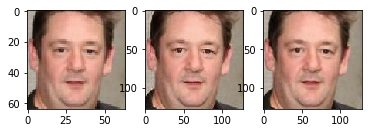

Step 3400:
    [D losses: Total=-0.014236, Wass_fake=-0.053441, Wass_real=0.035380, Wass_grad=0.003824]
    [G losses: Total=0.071468, Wass=0.064960, MSE=0.006509]


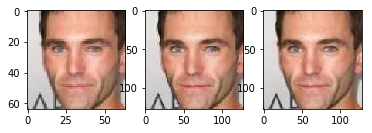

Step 3600:
    [D losses: Total=-0.013468, Wass_fake=-0.060922, Wass_real=0.042718, Wass_grad=0.004736]
    [G losses: Total=0.076194, Wass=0.070464, MSE=0.005730]


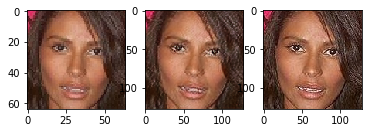

Step 3800:
    [D losses: Total=-0.019908, Wass_fake=-0.071443, Wass_real=0.044381, Wass_grad=0.007155]
    [G losses: Total=0.095337, Wass=0.089468, MSE=0.005869]


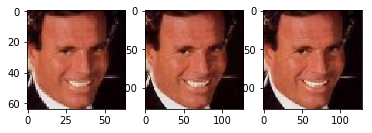

Step 4000:
    [D losses: Total=0.007275, Wass_fake=-0.090443, Wass_real=0.054067, Wass_grad=0.043651]
    [G losses: Total=0.064462, Wass=0.057413, MSE=0.007049]


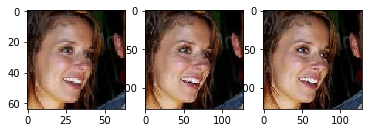

Step 4200:
    [D losses: Total=0.003548, Wass_fake=-0.079866, Wass_real=0.049705, Wass_grad=0.033709]
    [G losses: Total=0.065798, Wass=0.059265, MSE=0.006533]


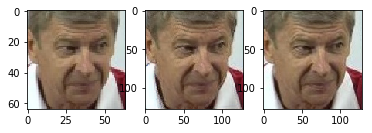

Step 4400:
    [D losses: Total=-0.027212, Wass_fake=-0.074690, Wass_real=0.041712, Wass_grad=0.005766]
    [G losses: Total=0.077058, Wass=0.072872, MSE=0.004187]


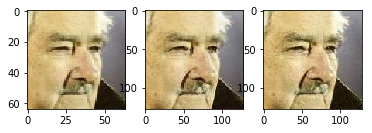

Step 4600:
    [D losses: Total=-0.014756, Wass_fake=-0.064317, Wass_real=0.047642, Wass_grad=0.001919]
    [G losses: Total=0.070001, Wass=0.064299, MSE=0.005702]


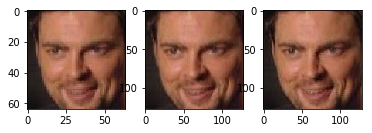

Step 4800:
    [D losses: Total=-0.002321, Wass_fake=-0.070481, Wass_real=0.052643, Wass_grad=0.015517]
    [G losses: Total=0.104923, Wass=0.100023, MSE=0.004900]


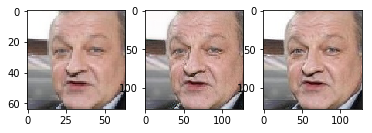

Step 5000:
    [D losses: Total=-0.007664, Wass_fake=-0.071147, Wass_real=0.050755, Wass_grad=0.012728]
    [G losses: Total=0.075302, Wass=0.069040, MSE=0.006262]


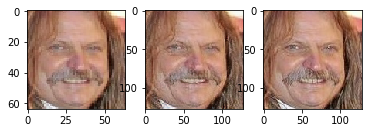

Step 5200:
    [D losses: Total=-0.000624, Wass_fake=-0.090691, Wass_real=0.060382, Wass_grad=0.029685]
    [G losses: Total=0.072497, Wass=0.067944, MSE=0.004553]


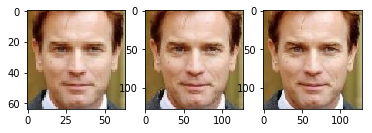

Step 5400:
    [D losses: Total=-0.004938, Wass_fake=-0.070955, Wass_real=0.052465, Wass_grad=0.013553]
    [G losses: Total=0.077270, Wass=0.071605, MSE=0.005665]


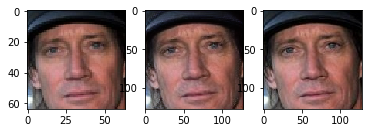

Step 5600:
    [D losses: Total=0.001459, Wass_fake=-0.070137, Wass_real=0.052500, Wass_grad=0.019096]
    [G losses: Total=0.073502, Wass=0.068560, MSE=0.004942]


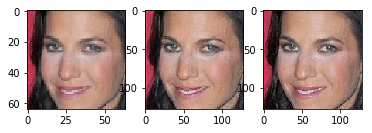

Step 5800:
    [D losses: Total=-0.011219, Wass_fake=-0.066352, Wass_real=0.048221, Wass_grad=0.006912]
    [G losses: Total=0.071628, Wass=0.065752, MSE=0.005876]


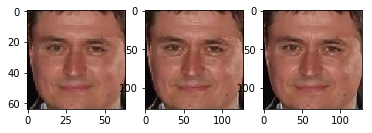

Step 6000:
    [D losses: Total=-0.019307, Wass_fake=-0.069602, Wass_real=0.045582, Wass_grad=0.004714]
    [G losses: Total=0.073401, Wass=0.068783, MSE=0.004617]


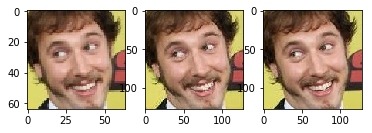

Step 6200:
    [D losses: Total=-0.018813, Wass_fake=-0.058695, Wass_real=0.037973, Wass_grad=0.001908]
    [G losses: Total=0.063511, Wass=0.059434, MSE=0.004077]


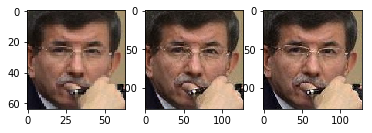

Step 6400:
    [D losses: Total=0.008155, Wass_fake=-0.075339, Wass_real=0.036429, Wass_grad=0.047065]
    [G losses: Total=0.068726, Wass=0.063958, MSE=0.004769]


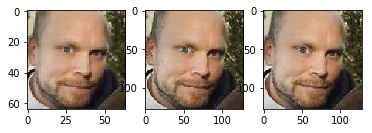

Step 6600:
    [D losses: Total=0.004887, Wass_fake=-0.069305, Wass_real=0.052410, Wass_grad=0.021783]
    [G losses: Total=0.076197, Wass=0.070043, MSE=0.006154]


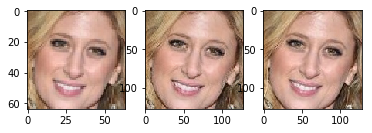

Step 6800:
    [D losses: Total=-0.022435, Wass_fake=-0.076297, Wass_real=0.050245, Wass_grad=0.003617]
    [G losses: Total=0.087005, Wass=0.080459, MSE=0.006545]


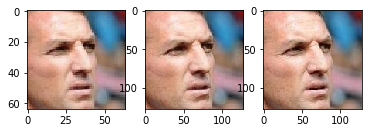

Step 7000:
    [D losses: Total=0.004125, Wass_fake=-0.066021, Wass_real=0.042923, Wass_grad=0.027224]
    [G losses: Total=0.059723, Wass=0.055946, MSE=0.003777]


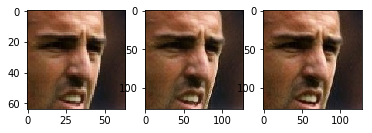

Step 7200:
    [D losses: Total=-0.009167, Wass_fake=-0.068173, Wass_real=0.047612, Wass_grad=0.011394]
    [G losses: Total=0.081692, Wass=0.076374, MSE=0.005318]


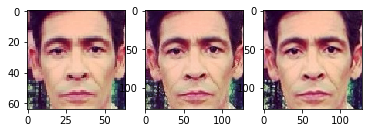

Step 7400:
    [D losses: Total=-0.011681, Wass_fake=-0.060427, Wass_real=0.040694, Wass_grad=0.008053]
    [G losses: Total=0.069619, Wass=0.064593, MSE=0.005026]


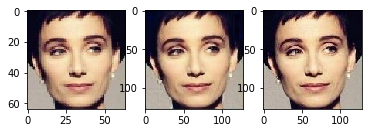

Step 7600:
    [D losses: Total=-0.016912, Wass_fake=-0.079084, Wass_real=0.056633, Wass_grad=0.005539]
    [G losses: Total=0.095905, Wass=0.086588, MSE=0.009317]


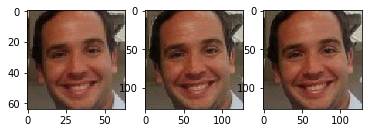

Step 7800:
    [D losses: Total=0.001749, Wass_fake=-0.055676, Wass_real=0.035018, Wass_grad=0.022407]
    [G losses: Total=0.074409, Wass=0.069528, MSE=0.004881]


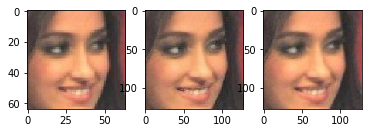

Step 8000:
    [D losses: Total=-0.018224, Wass_fake=-0.055652, Wass_real=0.036381, Wass_grad=0.001046]
    [G losses: Total=0.076849, Wass=0.070539, MSE=0.006311]


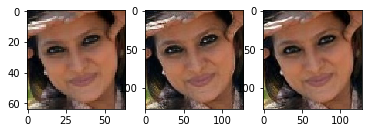

Step 8200:
    [D losses: Total=-0.010272, Wass_fake=-0.078344, Wass_real=0.055705, Wass_grad=0.012366]
    [G losses: Total=0.077164, Wass=0.071881, MSE=0.005283]


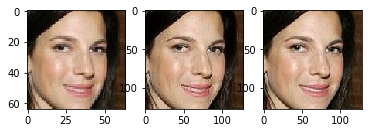

Step 8400:
    [D losses: Total=-0.006230, Wass_fake=-0.067770, Wass_real=0.046205, Wass_grad=0.015334]
    [G losses: Total=0.078993, Wass=0.074445, MSE=0.004548]


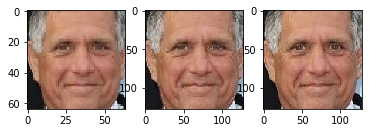

Step 8600:
    [D losses: Total=-0.005546, Wass_fake=-0.072310, Wass_real=0.051229, Wass_grad=0.015534]
    [G losses: Total=0.072159, Wass=0.066770, MSE=0.005389]


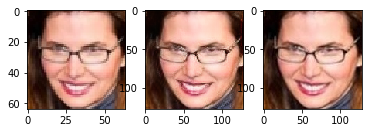

Step 8800:
    [D losses: Total=0.007297, Wass_fake=-0.076070, Wass_real=0.053097, Wass_grad=0.030270]
    [G losses: Total=0.088220, Wass=0.081750, MSE=0.006470]


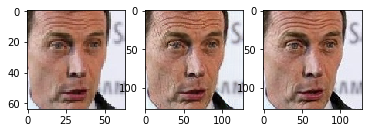

Step 9000:
    [D losses: Total=-0.020845, Wass_fake=-0.084529, Wass_real=0.059398, Wass_grad=0.004286]
    [G losses: Total=0.090259, Wass=0.085322, MSE=0.004937]


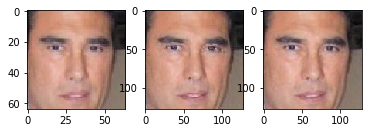

Step 9200:
    [D losses: Total=-0.014585, Wass_fake=-0.074208, Wass_real=0.052408, Wass_grad=0.007214]
    [G losses: Total=0.075403, Wass=0.070914, MSE=0.004488]


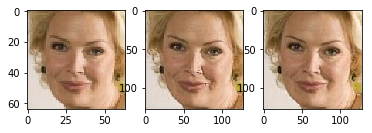

Step 9400:
    [D losses: Total=-0.003766, Wass_fake=-0.068051, Wass_real=0.055183, Wass_grad=0.009102]
    [G losses: Total=0.076721, Wass=0.070777, MSE=0.005944]


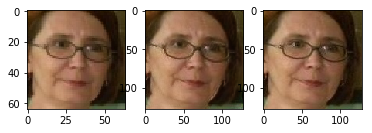

Step 9600:
    [D losses: Total=-0.020611, Wass_fake=-0.061622, Wass_real=0.037846, Wass_grad=0.003165]
    [G losses: Total=0.062727, Wass=0.057959, MSE=0.004768]


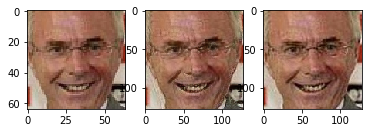

Step 9800:
    [D losses: Total=-0.003515, Wass_fake=-0.056943, Wass_real=0.043064, Wass_grad=0.010365]
    [G losses: Total=0.068601, Wass=0.063351, MSE=0.005250]


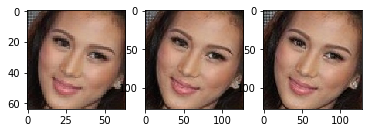

Step 10000:
    [D losses: Total=-0.035296, Wass_fake=-0.082855, Wass_real=0.046739, Wass_grad=0.000820]
    [G losses: Total=0.080195, Wass=0.073938, MSE=0.006256]


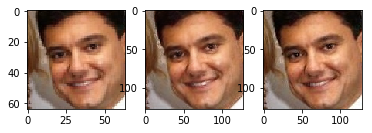

Step 10200:
    [D losses: Total=-0.003884, Wass_fake=-0.073072, Wass_real=0.057781, Wass_grad=0.011407]
    [G losses: Total=0.077060, Wass=0.072845, MSE=0.004214]


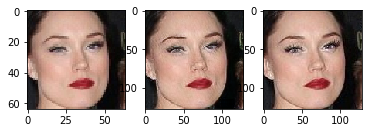

Step 10400:
    [D losses: Total=0.006376, Wass_fake=-0.078259, Wass_real=0.059418, Wass_grad=0.025217]
    [G losses: Total=0.071706, Wass=0.067556, MSE=0.004150]


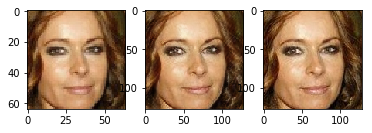

Step 10600:
    [D losses: Total=0.008754, Wass_fake=-0.062196, Wass_real=0.040643, Wass_grad=0.030307]
    [G losses: Total=0.085636, Wass=0.079341, MSE=0.006295]


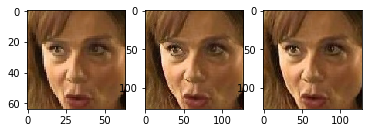

Step 10800:
    [D losses: Total=-0.001314, Wass_fake=-0.063253, Wass_real=0.035993, Wass_grad=0.025946]
    [G losses: Total=0.083967, Wass=0.080003, MSE=0.003964]


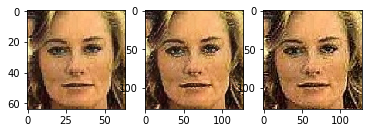

Step 11000:
    [D losses: Total=0.003069, Wass_fake=-0.086863, Wass_real=0.059836, Wass_grad=0.030096]
    [G losses: Total=0.082083, Wass=0.075875, MSE=0.006207]


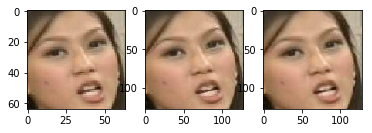

Step 11200:
    [D losses: Total=0.002621, Wass_fake=-0.050042, Wass_real=0.038330, Wass_grad=0.014333]
    [G losses: Total=0.065761, Wass=0.059895, MSE=0.005866]


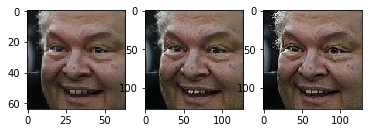

Step 11400:
    [D losses: Total=-0.000261, Wass_fake=-0.068878, Wass_real=0.051200, Wass_grad=0.017417]
    [G losses: Total=0.076968, Wass=0.072291, MSE=0.004677]


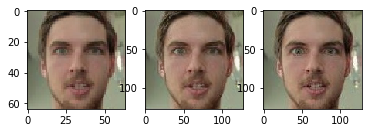

Step 11600:
    [D losses: Total=-0.021163, Wass_fake=-0.086130, Wass_real=0.061885, Wass_grad=0.003082]
    [G losses: Total=0.073750, Wass=0.070179, MSE=0.003571]


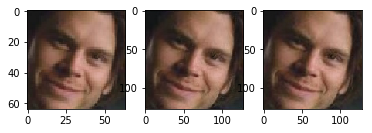

Step 11800:
    [D losses: Total=0.010060, Wass_fake=-0.081043, Wass_real=0.062000, Wass_grad=0.029103]
    [G losses: Total=0.086138, Wass=0.081617, MSE=0.004520]


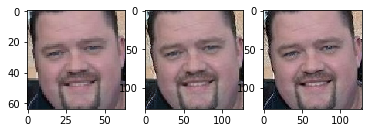

Step 12000:
    [D losses: Total=0.000743, Wass_fake=-0.074584, Wass_real=0.053536, Wass_grad=0.021792]
    [G losses: Total=0.086931, Wass=0.080934, MSE=0.005997]


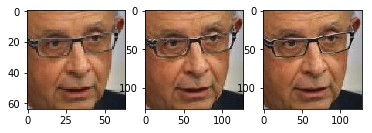

Step 12200:
    [D losses: Total=-0.015099, Wass_fake=-0.070143, Wass_real=0.053161, Wass_grad=0.001882]
    [G losses: Total=0.068559, Wass=0.063602, MSE=0.004958]


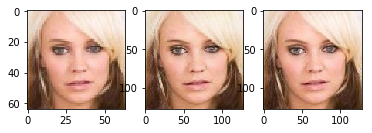

Step 12400:
    [D losses: Total=-0.020547, Wass_fake=-0.072886, Wass_real=0.051383, Wass_grad=0.000956]
    [G losses: Total=0.073441, Wass=0.067909, MSE=0.005532]


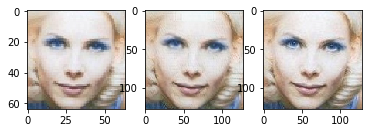

Step 12600:
    [D losses: Total=-0.007658, Wass_fake=-0.076494, Wass_real=0.052718, Wass_grad=0.016119]
    [G losses: Total=0.087339, Wass=0.082706, MSE=0.004633]


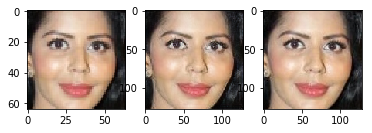

Step 12800:
    [D losses: Total=-0.016908, Wass_fake=-0.067738, Wass_real=0.047087, Wass_grad=0.003743]
    [G losses: Total=0.093118, Wass=0.089089, MSE=0.004029]


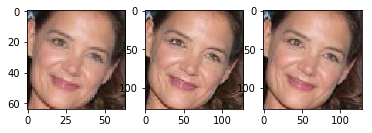

Step 13000:
    [D losses: Total=0.001491, Wass_fake=-0.065723, Wass_real=0.048454, Wass_grad=0.018760]
    [G losses: Total=0.073879, Wass=0.069192, MSE=0.004688]


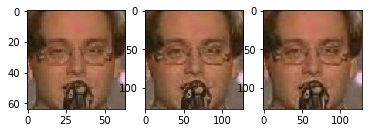

Step 13200:
    [D losses: Total=0.000530, Wass_fake=-0.073338, Wass_real=0.058056, Wass_grad=0.015812]
    [G losses: Total=0.085942, Wass=0.080964, MSE=0.004978]


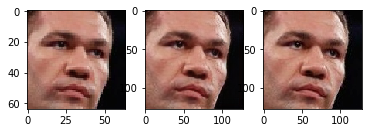

Step 13400:
    [D losses: Total=-0.014165, Wass_fake=-0.084643, Wass_real=0.048482, Wass_grad=0.021995]
    [G losses: Total=0.067734, Wass=0.062281, MSE=0.005453]


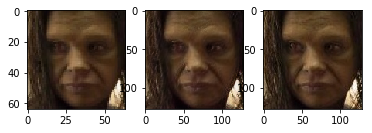

Step 13600:
    [D losses: Total=-0.016984, Wass_fake=-0.063724, Wass_real=0.044108, Wass_grad=0.002632]
    [G losses: Total=0.065673, Wass=0.061514, MSE=0.004158]


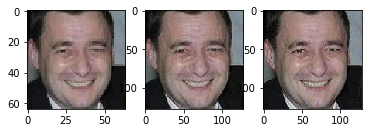

Step 13800:
    [D losses: Total=-0.007858, Wass_fake=-0.075878, Wass_real=0.058447, Wass_grad=0.009573]
    [G losses: Total=0.091851, Wass=0.086679, MSE=0.005172]


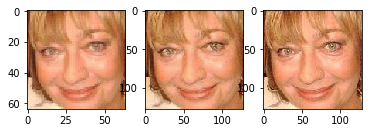

Step 14000:
    [D losses: Total=-0.016373, Wass_fake=-0.078226, Wass_real=0.058299, Wass_grad=0.003554]
    [G losses: Total=0.089625, Wass=0.084889, MSE=0.004736]


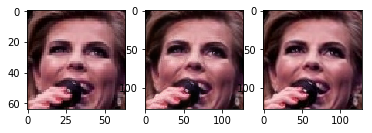

Step 14200:
    [D losses: Total=-0.010758, Wass_fake=-0.072288, Wass_real=0.050864, Wass_grad=0.010666]
    [G losses: Total=0.075410, Wass=0.069988, MSE=0.005422]


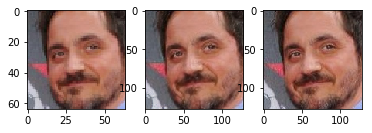

Step 14400:
    [D losses: Total=0.028558, Wass_fake=-0.069569, Wass_real=0.042111, Wass_grad=0.056016]
    [G losses: Total=0.057032, Wass=0.052633, MSE=0.004399]


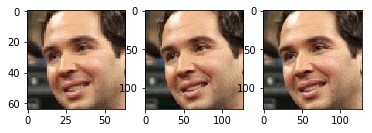

Step 14600:
    [D losses: Total=-0.013375, Wass_fake=-0.071109, Wass_real=0.050252, Wass_grad=0.007482]
    [G losses: Total=0.068237, Wass=0.064248, MSE=0.003989]


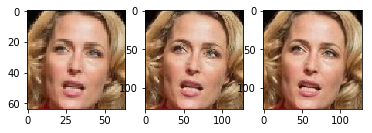

Step 14800:
    [D losses: Total=-0.007852, Wass_fake=-0.062556, Wass_real=0.047694, Wass_grad=0.007009]
    [G losses: Total=0.077334, Wass=0.071274, MSE=0.006061]


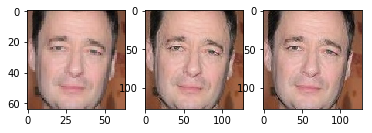

Step 15000:
    [D losses: Total=-0.009871, Wass_fake=-0.061103, Wass_real=0.044258, Wass_grad=0.006974]
    [G losses: Total=0.082556, Wass=0.078303, MSE=0.004253]


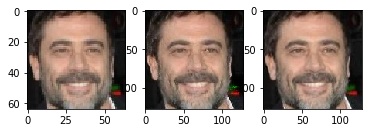

Step 15200:
    [D losses: Total=-0.011906, Wass_fake=-0.058446, Wass_real=0.044823, Wass_grad=0.001716]
    [G losses: Total=0.064683, Wass=0.059409, MSE=0.005274]


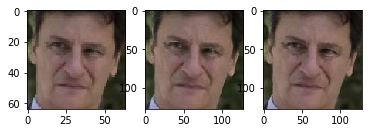

Step 15400:
    [D losses: Total=-0.005220, Wass_fake=-0.066157, Wass_real=0.041218, Wass_grad=0.019719]
    [G losses: Total=0.063483, Wass=0.058247, MSE=0.005236]


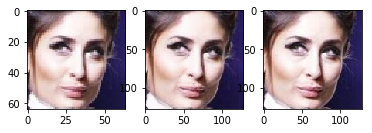

Step 15600:
    [D losses: Total=-0.011599, Wass_fake=-0.064891, Wass_real=0.049034, Wass_grad=0.004257]
    [G losses: Total=0.079325, Wass=0.073531, MSE=0.005793]


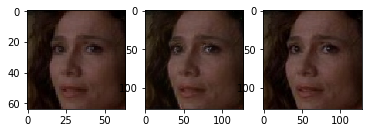

Step 15800:
    [D losses: Total=-0.017533, Wass_fake=-0.072339, Wass_real=0.053399, Wass_grad=0.001408]
    [G losses: Total=0.079437, Wass=0.073630, MSE=0.005807]


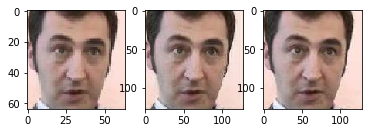

Step 16000:
    [D losses: Total=0.020284, Wass_fake=-0.059811, Wass_real=0.044348, Wass_grad=0.035747]
    [G losses: Total=0.080541, Wass=0.075662, MSE=0.004879]


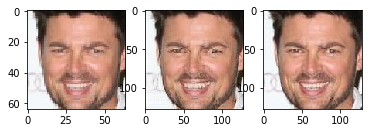

Step 16200:
    [D losses: Total=-0.032846, Wass_fake=-0.080157, Wass_real=0.045973, Wass_grad=0.001339]
    [G losses: Total=0.077650, Wass=0.073524, MSE=0.004126]


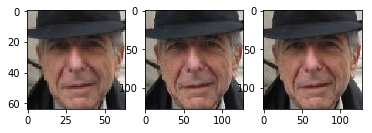

Step 16400:
    [D losses: Total=-0.014060, Wass_fake=-0.069486, Wass_real=0.051255, Wass_grad=0.004171]
    [G losses: Total=0.074593, Wass=0.068426, MSE=0.006167]


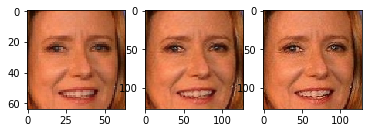

Step 16600:
    [D losses: Total=0.010738, Wass_fake=-0.065830, Wass_real=0.049949, Wass_grad=0.026619]
    [G losses: Total=0.087357, Wass=0.082425, MSE=0.004932]


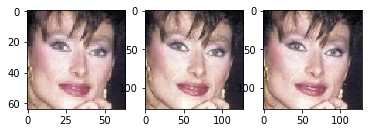

Step 16800:
    [D losses: Total=-0.022615, Wass_fake=-0.080935, Wass_real=0.056072, Wass_grad=0.002249]
    [G losses: Total=0.076946, Wass=0.072842, MSE=0.004104]


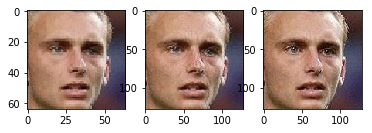

Step 17000:
    [D losses: Total=-0.017146, Wass_fake=-0.081883, Wass_real=0.058875, Wass_grad=0.005863]
    [G losses: Total=0.077471, Wass=0.072011, MSE=0.005459]


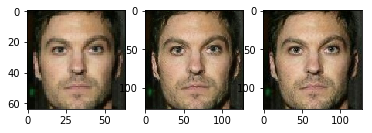

Step 17200:
    [D losses: Total=-0.017084, Wass_fake=-0.067056, Wass_real=0.043208, Wass_grad=0.006764]
    [G losses: Total=0.098767, Wass=0.092844, MSE=0.005923]


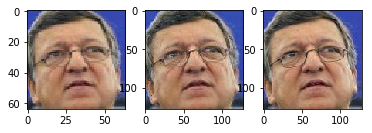

Step 17400:
    [D losses: Total=-0.003919, Wass_fake=-0.074220, Wass_real=0.058649, Wass_grad=0.011652]
    [G losses: Total=0.084278, Wass=0.079545, MSE=0.004733]


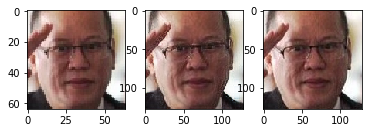

Step 17600:
    [D losses: Total=-0.017546, Wass_fake=-0.072960, Wass_real=0.049242, Wass_grad=0.006173]
    [G losses: Total=0.090436, Wass=0.086202, MSE=0.004234]


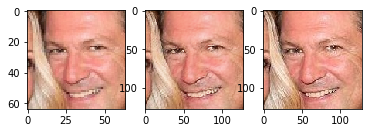

Step 17800:
    [D losses: Total=0.000018, Wass_fake=-0.069390, Wass_real=0.049927, Wass_grad=0.019481]
    [G losses: Total=0.064098, Wass=0.059788, MSE=0.004310]


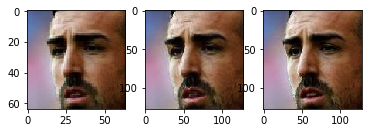

Step 18000:
    [D losses: Total=0.018884, Wass_fake=-0.065442, Wass_real=0.049254, Wass_grad=0.035072]
    [G losses: Total=0.071503, Wass=0.066488, MSE=0.005015]


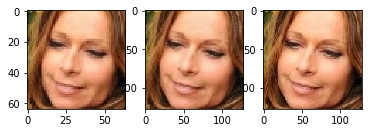

Step 18200:
    [D losses: Total=-0.015904, Wass_fake=-0.067580, Wass_real=0.050021, Wass_grad=0.001655]
    [G losses: Total=0.073278, Wass=0.069125, MSE=0.004153]


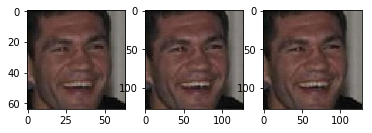

Step 18400:
    [D losses: Total=-0.013271, Wass_fake=-0.064093, Wass_real=0.047775, Wass_grad=0.003047]
    [G losses: Total=0.070265, Wass=0.065791, MSE=0.004474]


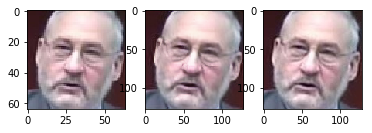

Step 18600:
    [D losses: Total=0.005467, Wass_fake=-0.076297, Wass_real=0.057508, Wass_grad=0.024257]
    [G losses: Total=0.076728, Wass=0.071128, MSE=0.005600]


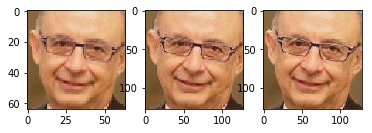

Step 18800:
    [D losses: Total=-0.016741, Wass_fake=-0.073520, Wass_real=0.052606, Wass_grad=0.004174]
    [G losses: Total=0.074650, Wass=0.070098, MSE=0.004551]


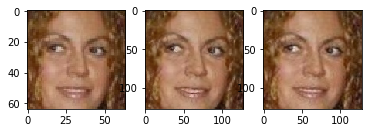

Step 19000:
    [D losses: Total=0.005257, Wass_fake=-0.073680, Wass_real=0.059678, Wass_grad=0.019259]
    [G losses: Total=0.080126, Wass=0.074048, MSE=0.006078]


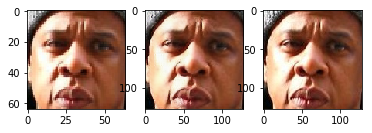

Step 19200:
    [D losses: Total=-0.004676, Wass_fake=-0.062312, Wass_real=0.050304, Wass_grad=0.007332]
    [G losses: Total=0.079441, Wass=0.075045, MSE=0.004397]


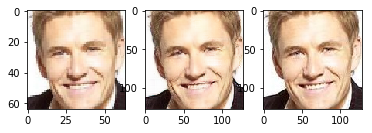

Step 19400:
    [D losses: Total=-0.005129, Wass_fake=-0.079233, Wass_real=0.063979, Wass_grad=0.010125]
    [G losses: Total=0.093482, Wass=0.087414, MSE=0.006068]


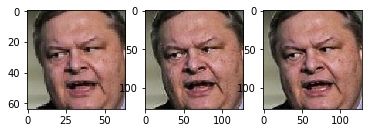

Step 19600:
    [D losses: Total=-0.003926, Wass_fake=-0.053767, Wass_real=0.045803, Wass_grad=0.004038]
    [G losses: Total=0.064859, Wass=0.061920, MSE=0.002939]


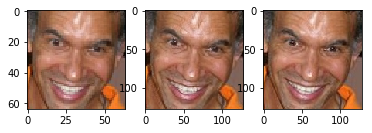

Step 19800:
    [D losses: Total=-0.018756, Wass_fake=-0.076816, Wass_real=0.056485, Wass_grad=0.001575]
    [G losses: Total=0.080745, Wass=0.075715, MSE=0.005030]


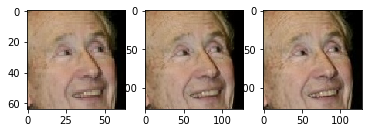

Step 20000:
    [D losses: Total=-0.010361, Wass_fake=-0.061396, Wass_real=0.048122, Wass_grad=0.002912]
    [G losses: Total=0.069846, Wass=0.065534, MSE=0.004312]


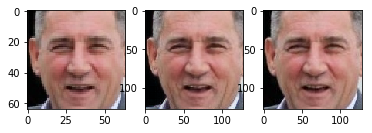

Step 20200:
    [D losses: Total=-0.003423, Wass_fake=-0.067746, Wass_real=0.052637, Wass_grad=0.011686]
    [G losses: Total=0.076430, Wass=0.071813, MSE=0.004617]


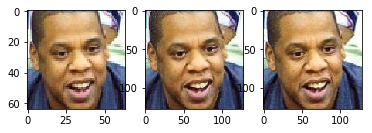

Step 20400:
    [D losses: Total=-0.014508, Wass_fake=-0.074752, Wass_real=0.050718, Wass_grad=0.009526]
    [G losses: Total=0.069684, Wass=0.065070, MSE=0.004614]


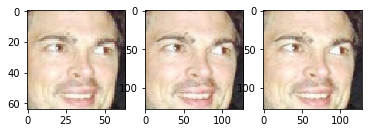

KeyboardInterrupt: 

In [6]:
for step in range(1, train_steps + 1):
    ind = 1
    d = im_names[ind]
    path1 = path + dirs[ind] + "/"

    num_images = len(d)
    image_size = image_sizes[ind]
    # ---------------------
    #  Train Discriminator
    # ---------------------
    wass_weight = 100
    sample_weight_disc = [wass_weight*np.ones(batch_size)*1/(image_size**2) for ii in range(2)] + [np.ones(batch_size)]
    sample_weight_gen = [wass_weight*np.ones(batch_size)*1/(image_size**2) for ii in range(1)] + [np.ones(batch_size)]
    for train_discriminator in range(repeat_discriminator_training_n_times):

        random_idxs = np.random.randint(num_images, size=batch_size)
        imgs_to_pass_through_upscaler = load_batch(path1, d, random_idxs)
        low_res_imgs_to_pass_through_upscaler = reduce_resolution(imgs_to_pass_through_upscaler)

        random_idxs = np.random.randint(num_images, size=batch_size)
        real_imgs = load_batch(path1, d, random_idxs)
        low_res_imgs_to_pass_through_discriminator = reduce_resolution(real_imgs)

        # Train the discriminator
        d_loss = discriminator.train_on_batch( 
            x=[low_res_imgs_to_pass_through_upscaler, low_res_imgs_to_pass_through_discriminator, real_imgs], # Training data
            y=[negative_y, positive_y, dummy_y], 
            sample_weight=sample_weight_disc) # Labels
    # ---------------------
    #  Train upscaler
    # ---------------------

    random_idxs = np.random.randint(num_images, size=batch_size)
    original_imgs = load_batch(path1, d, random_idxs)
    new_low_res_imgs = reduce_resolution(original_imgs)
    
    # Train the upscaler
    g_loss = combined.train_on_batch(
        x=new_low_res_imgs, 
        y=[positive_y, original_imgs], 
        sample_weight=sample_weight_gen)
    
    if step % print_every_n_steps == 0:
        # Store metrics over time
        training_metrics['step'].append(step)
        training_metrics['d_total_loss'].append(d_loss[0])
        training_metrics['d_w_fake_loss'].append(d_loss[1])
        training_metrics['d_w_real_loss'].append(d_loss[2])
        training_metrics['d_grad_loss'].append(d_loss[3])
        training_metrics['g_total_loss'].append(g_loss[0])
        training_metrics['g_w_loss'].append(g_loss[1])
        training_metrics['g_MSE_loss'].append(g_loss[2])
        
        # Print current metrics
        if print_results:
            print("Step {}:".format(step))
            print("    [D losses: Total={:0.6f}, Wass_fake={:0.6f}, Wass_real={:0.6f}, Wass_grad={:0.6f}]".format(
                training_metrics['d_total_loss'][-1],
                training_metrics['d_w_fake_loss'][-1],
                training_metrics['d_w_real_loss'][-1],
                training_metrics['d_grad_loss'][-1]))
            print("    [G losses: Total={:0.6f}, Wass={:0.6f}, MSE={:0.6f}]".format(
                training_metrics['g_total_loss'][-1],
                training_metrics['g_w_loss'][-1],
                training_metrics['g_MSE_loss'][-1]))
        
        # Plot example low_res vs upsampling vs original
        if plot_results:
            gen_imgs = upscaler.predict(low_res_imgs_to_pass_through_discriminator)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(np.array((low_res_imgs_to_pass_through_discriminator[0, :, :, ::-1] + 1.0)*255/2, dtype=np.uint8))
            ax2.imshow(np.array((gen_imgs[0, :, :, ::-1] + 1.0)*255/2, dtype=np.uint8))
            ax3.imshow(np.array((real_imgs[0, :, :, ::-1] + 1.0)*255/2, dtype=np.uint8))
            plt.show()

In [42]:
generator.save('./models/generator_faces60000.h5')
discriminator.save('./models/discriminator_faces60000.h5')
combined.save('./models/combined_faces60000.h5')

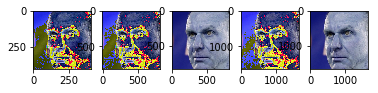

In [70]:
from PIL import Image
import PIL
n = 0
imgs3 = load_batch(path1, d, idx)
imx = Image.fromarray(np.array((imgs3[n]+1.)*255/2, dtype='uint8'))
imx2 = imx.resize((410*2, 410*2), resample=PIL.Image.BICUBIC)
imx4 = imx.resize((410*4, 410*4), resample=PIL.Image.BICUBIC)
HD = generator.predict(imgs3)
HD1 = generator.predict(np.expand_dims(HD[0], axis=0))
fig, ax = plt.subplots(1, 5)
ax[0].imshow(imgs3[n])
ax[1].imshow(HD[n])
ax[2].imshow(imx2)
ax[3].imshow(HD1[n])
ax[4].imshow(imx4)
plt.show()

In [43]:
import imageio
n=1
imageio.imwrite('./image_examples/gen_img60000.jpg', gen_imgs[n])
imageio.imwrite('./image_examples/input_img60000.jpg', noise1[n])
imageio.imwrite('./image_examples/original_img60000.jpg', imgs1[n])

C:\Users\Daniel\Anaconda3\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.9999971389770508, 0.9738192558288574]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\Daniel\Anaconda3\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.0, 1.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [71]:
imageio.imwrite('./image_examples/gen_img60000x2.jpg', HD[n])
imageio.imwrite('./image_examples/input_img60000x1.jpg', imgs3[n])
imageio.imwrite('./image_examples/gen_img60000x4.jpg', HD1[n])


imageio.imwrite('./image_examples/interpolatedx2.jpg', np.array(imx2))
imageio.imwrite('./image_examples/interpolatedx4.jpg', np.array(imx4))

C:\Users\Daniel\Anaconda3\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.9998878240585327, 0.9832291603088379]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\Daniel\Anaconda3\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.0, 1.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
C:\Users\Daniel\Anaconda3\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-1.0, 0.9582899808883667]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
